# MNIST Handwritten Digits — PyTorch MLP Tutorial (IPython Notebook)
This notebook demonstrates a simple **Multilayer Perceptron (MLP)** for classifying MNIST handwritten digits using PyTorch.

We'll cover:
- Loading and transforming data  
- Building a simple feed-forward neural network  
- Training and evaluation loops  
- Visualizing training progress  
- Making predictions and saving the model


In [8]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
print('Torch version:', torch.__version__)

Torch version: 2.2.1


## Load Data

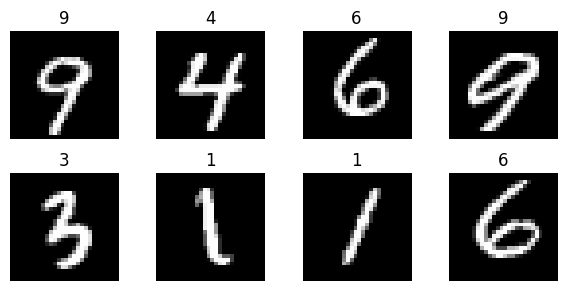

In [9]:
# Data transforms and loaders
batch_size = 128
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Show a few samples
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
plt.figure(figsize=(6,3))
for i in range(8):
    ax = plt.subplot(2,4,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
    plt.title(str(int(example_targets[i])))
    plt.axis('off')
plt.tight_layout()
plt.show()

## Define MLP Model

In [10]:
# Define a simple MLP
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.0)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.fc4(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP().to(device)
print(model)

MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.0, inplace=False)
)


## Training Loop

In [11]:
# Training and evaluation loops
def train(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * data.size(0)
        _, predicted = outputs.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
    return running_loss/total, 100. * correct/total

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            running_loss += loss.item() * data.size(0)
            _, predicted = outputs.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    return running_loss/total, 100. * correct/total

# Hyperparameters
lr = 0.001
epochs = 10

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_losses, test_losses = [], []
train_accs, test_accs = [], []

start_time = time.time()
for epoch in range(1, epochs+1):
    t_loss, t_acc = train(model, train_loader, optimizer, criterion, device)
    v_loss, v_acc = evaluate(model, test_loader, criterion, device)
    train_losses.append(t_loss); test_losses.append(v_loss)
    train_accs.append(t_acc); test_accs.append(v_acc)
    print(f'Epoch {epoch:02d}: Train loss={t_loss:.4f}, acc={t_acc:.2f}%, Test loss={v_loss:.4f}, acc={v_acc:.2f}%')
print("Training completed in %.2fs" % (time.time() - start_time))

Epoch 01: Train loss=0.2999, acc=90.89%, Test loss=0.1352, acc=96.00%
Epoch 02: Train loss=0.1098, acc=96.69%, Test loss=0.1024, acc=96.60%
Epoch 03: Train loss=0.0761, acc=97.65%, Test loss=0.0892, acc=97.37%
Epoch 04: Train loss=0.0573, acc=98.19%, Test loss=0.0889, acc=97.42%
Epoch 05: Train loss=0.0450, acc=98.53%, Test loss=0.0778, acc=97.61%
Epoch 06: Train loss=0.0382, acc=98.79%, Test loss=0.0789, acc=97.62%
Epoch 07: Train loss=0.0297, acc=99.06%, Test loss=0.0809, acc=97.75%
Epoch 08: Train loss=0.0278, acc=99.07%, Test loss=0.0854, acc=97.60%
Epoch 09: Train loss=0.0226, acc=99.23%, Test loss=0.0888, acc=97.64%
Epoch 10: Train loss=0.0195, acc=99.35%, Test loss=0.0906, acc=97.72%
Training completed in 153.02s


## Visualization

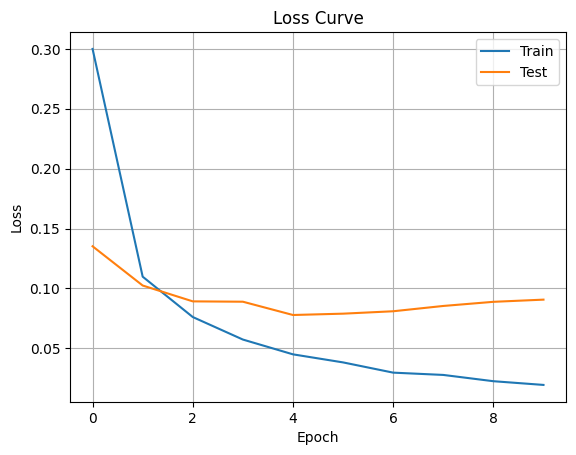

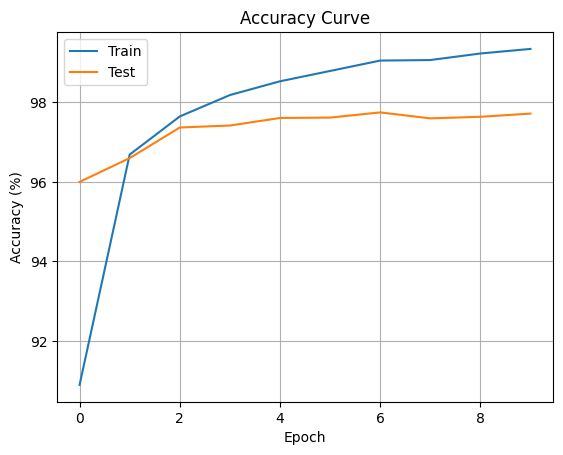

In [12]:
# Plot training curves
plt.figure()
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(train_accs, label='Train')
plt.plot(test_accs, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Curve')
plt.grid(True)
plt.show()

## Predictions

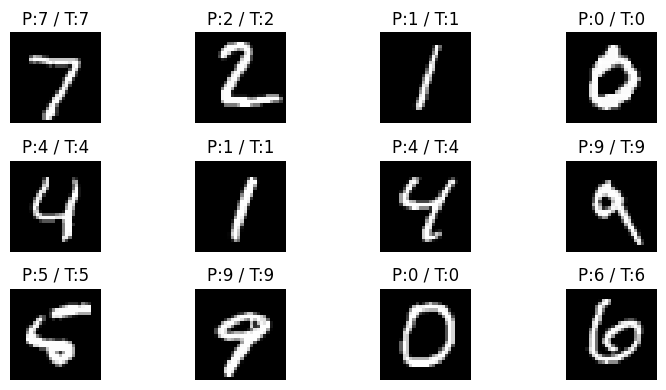

In [13]:
# Example predictions
model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(8,4))
for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(images[i][0].cpu(), cmap='gray')
    plt.title(f'P:{int(preds[i])} / T:{int(labels[i])}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## Save Model

In [14]:
# Save model
torch.save(model.state_dict(), 'mnist_mlp.pth')
print("Model saved as mnist_mlp.pth")

Model saved as mnist_mlp.pth


### Notes
- This MLP performs well (~97% accuracy).  
- Try deeper layers or different hidden sizes.  
- Use batch normalization or dropout tuning.  
- For faster training, enable GPU (`torch.cuda.is_available()`).  
